# Librerías y configuración

In [1]:
import os
import re
import time

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import tqdm.notebook as tqdm
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaMulticore
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

os.chdir(
    "C:/Users/luism/Documents/Programacion_local/Clase/4o Año/Descubrimiento Datos Complejos/DCDC-Proyecto-Stocks/"
)
os.listdir()

BASE_PATH = "C:/Users/luism/Documents/Programacion_local/Clase/4o Año/Descubrimiento Datos Complejos/DCDC-Proyecto-Stocks/notebooks/Luis/mineria_datos"
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaMulticore
from wordcloud import WordCloud

os.chdir(
    "C:/Users/luism/Documents/Programacion_local/Clase/4o Año/Descubrimiento Datos Complejos/DCDC-Proyecto-Stocks"
)


os.listdir()

SEED = 289995

In [2]:
# Descargar recursos necesarios de NLTK
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luism\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luism\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luism\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\luism\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Cargar datos

In [3]:
df_noticias_fecha: pd.DataFrame = pd.read_pickle(
    r"C:\Users\luism\Documents\Programacion_local\Clase\4o Año\Descubrimiento Datos Complejos\DCDC-Proyecto-Stocks\notebooks\Luis\mineria_datos\Datos\02_df_noticias_fecha.pkl"
)

In [4]:
display(df_noticias_fecha.head())
print(df_noticias_fecha.shape)

,date,news
0,2012-01-03 00:00:00+00:00,'Mad Money Lightning Round': Stay Long Sandridge
1,2012-01-03 00:00:00+00:00,Cramer's 'Mad Money' Recap: Betting Against th...
2,2012-01-03 00:00:00+00:00,'Mad Money Lightning Round': Stay Long Sandridge
3,2012-01-03 00:00:00+00:00,BioLineRx Announces Initiation of CE Mark Regi...
4,2012-01-03 00:00:00+00:00,Hearing Rumors of the Death of Fidel Castro


(2303734, 2)


# Añadir preprocesado diferente

In [5]:
# Obtenemos los tickers del NASDAQ
df_ticker = pd.read_csv("C:/Users/luism/Documents/Programacion_local/Clase/4o Año/Descubrimiento Datos Complejos/DCDC-Proyecto-Stocks/data/nasdaq-listed-symbols_csv.csv")

tickers_list = df_ticker["Symbol"].tolist()
tickers_list += [ticker.capitalize() for ticker in tickers_list]
tickers_list += [ticker.lower() for ticker in tickers_list]
tickers_set = set(tickers_list)

In [6]:
# Preprocesamiento de noticias
def preprocess_text(text, p_bar):
    if not text:
        p_bar.update(1)
        return []
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
        and token not in tickers_set # Here we add the condition to remove tickers since in previous runs topics had a lot of tickers in them giving no useful information
    ]
    p_bar.update(1)
    return tokens

In [7]:
# Barra de progreso para el preprocesamiento de noticias
p_bar = tqdm.tqdm(total=df_noticias_fecha.shape[0], desc="Preprocessing news")

# Aplica la función de preprocesamiento a la columna 'news'
df_noticias_fecha["news_processed"] = df_noticias_fecha["news"].apply(
    preprocess_text, args=(p_bar,)
)
p_bar.close()

df_completo = df_noticias_fecha.copy()

Preprocessing news:   0%|          | 0/2303734 [00:00<?, ?it/s]

In [8]:
df_completo.to_pickle("notebooks/Luis/Entrega_4/data/df_noticias_procesado_tickers_stopwords.pkl")

# Probar mdoelo con una muestra

In [9]:
SAMPLE_SIZE = len(df_completo)

In [10]:
# Muestra un subconjunto del dataframe original
sampled_df = (
    df_completo.sample(n=SAMPLE_SIZE, random_state=SEED)
    .sort_values("date")
    .reset_index(drop=True)
)

# Imprime la longitud original y la longitud muestreada del dataframe
print(
    "Longitud original:",
    len(df_completo),
    "Longitud muestreada:",
    len(sampled_df),
    f" - {len(sampled_df) / len(df_completo):.4f}% del total",
)

Longitud original: 2303734 Longitud muestreada: 2303734  - 1.0000% del total


In [11]:
# Crea un diccionario a partir de las noticias procesadas
dictionary = Dictionary(
    tqdm.tqdm(sampled_df["news_processed"], desc="Creando diccionario")
)
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("\nTamaño del vocabulario:", len(dictionary))

# Crea un corpus a partir del diccionario
corpus = [
    dictionary.doc2bow(doc)
    for doc in tqdm.tqdm(sampled_df["news_processed"], desc="Creando corpus")
]

Creando diccionario:   0%|          | 0/2303734 [00:00<?, ?it/s]


Tamaño del vocabulario: 79113


Creando corpus:   0%|          | 0/2303734 [00:00<?, ?it/s]

# Probar con todo el dataset el n_topics = 5 como en previos experimentos

In [12]:
# Crea un diccionario a partir de las noticias procesadas
dictionary = Dictionary(
    tqdm.tqdm(sampled_df["news_processed"], desc="Creando diccionario")
)
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("\nTamaño del vocabulario:", len(dictionary))

# Crea un corpus a partir del diccionario
corpus = [
    dictionary.doc2bow(doc)
    for doc in tqdm.tqdm(sampled_df["news_processed"], desc="Creando corpus")
]

texts = sampled_df["news_processed"].tolist()

Creando diccionario:   0%|          | 0/2303734 [00:00<?, ?it/s]


Tamaño del vocabulario: 79113


Creando corpus:   0%|          | 0/2303734 [00:00<?, ?it/s]

In [13]:
num_topics = 5

In [14]:
start_time = time.time()
print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(start_time))}")

dtm = LdaMulticore(
    corpus=corpus,
    num_topics=num_topics,
    id2word=dictionary,
    passes=10,
    random_state=SEED,
    workers=12,
)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time LDA: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")


# Calcular la coherencia
start_time = time.time()
coherence_model = CoherenceModel(
    model=dtm, texts=texts, dictionary=dictionary, coherence="c_v"
)
coherence_score = coherence_model.get_coherence()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time Coherence: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")

Start time: 2024-12-17 22:54:33
Elapsed time LDA: 00:10:41
Elapsed time Coherence: 00:00:28


# Resultados

In [15]:
coherence_score = coherence_model.get_coherence()

print(f"Coherence Score: {coherence_score:.3f}")

Coherence Score: 0.503


In [16]:
dtm.num_topics

5

In [17]:
for topic_n, topic_weigths_str in dtm.print_topics(num_topics=num_topics, num_words=5):

    print(f"Topic {topic_n}: {topic_weigths_str}")

Topic 0: 0.028*"tesla" + 0.018*"tslaq" + 0.010*"year" + 0.010*"week" + 0.009*"model"
Topic 1: 0.045*"market" + 0.039*"spy" + 0.034*"stock" + 0.027*"price" + 0.024*"spx"
Topic 2: 0.013*"like" + 0.010*"day" + 0.009*"see" + 0.009*"get" + 0.009*"today"
Topic 3: 0.029*"earnings" + 0.023*"apple" + 0.022*"amazon" + 0.012*"sale" + 0.011*"inc"
Topic 4: 0.026*"stock" + 0.024*"spy" + 0.015*"baba" + 0.014*"twtr" + 0.013*"roku"


# Plotting results function

In [18]:
def plot_topics_words():
    # Barplot topics most important words

    topic_weigths = []

    for topic_n, topic_weigths_str in dtm.print_topics(num_topics=num_topics, num_words=5):
        
        weigths = topic_weigths_str.split(" + ")
        weigths_topic_n = []
        for weight in weigths:
            
            tup = weight.split("*")
            tup = (float(tup[0]), tup[1].replace("\"", ""))

            weigths_topic_n.append(tup)
        topic_weigths.append(weigths_topic_n)    
    topic_weigths

    fig = go.Figure()

    for i, topic in enumerate(topic_weigths):
        x = [word for weight, word in topic]
        y = [weight for weight, word in topic]
        fig.add_trace(go.Bar(x=x, y=y, name=f"Topic {i+1}"))

    fig.update_layout(barmode="group", title="Top 5 words for each topic", xaxis_title="Words", yaxis_title="Weights")
    fig.show()

def plot_topic_distr_across_corpus():
    # Topics distribution in the corpus
    topics_distribution = [dtm.get_document_topics(doc) for doc in corpus]
    # Calculate average weight for each topic
    topic_weights = np.zeros(num_topics)
    for dist in topics_distribution:
        for topic_id, weight in dist:
            topic_weights[topic_id] += weight
    topic_weights /= len(corpus)

    # Create visualization
    fig = go.Figure(data=[
        go.Bar(
            x=[f"Topic {i+1}" for i in range(num_topics)],
            y=topic_weights
        )
    ])

    fig.update_layout(
        title="Topic Distribution Across Corpus",
        xaxis_title="Topics",
        yaxis_title="Average Weight",
        yaxis_range=[0,1]
    )
    fig.show()

def plot_heatmap_topic_distr_per_document():
    first_n = len(corpus)
    topics_distribution = [dtm.get_document_topics(doc) for doc in corpus]

    doc_topics = np.zeros((len(corpus[:first_n]), num_topics))
    for i in range(len(corpus[:first_n])):
        topic_dist = topics_distribution[i]
        for topic_id, weight in topic_dist:
            doc_topics[i, topic_id] = weight

    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        doc_topics[:first_n],  # Show first 50 documents
        cmap='YlOrRd',
        xticklabels=[f'Topic {i+1}' for i in range(num_topics)],
    )
    plt.title('Topic Distribution in Documents')
    plt.xlabel('Topics')
    plt.ylabel('Documents')
    plt.show()

def plot_word_cloud():
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))

    # Create word cloud for each topic
    for t in range(num_topics):
        # Get word weights for topic
        words = dict(dtm.show_topic(t, 30))
        
        # Generate word cloud
        wordcloud = WordCloud(
            background_color='white',
            width=800,
            height=400
        ).generate_from_frequencies(words)
        
        ax = axes[t // 2, t % 2]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_title(f'Topic {t+1}')

    # Turn off the axis for the last subplot
    axes[2, 1].axis('off')

    plt.tight_layout()
    plt.show()

def plot_All():
    plot_word_cloud()
    plot_topics_words()
    plot_topic_distr_across_corpus()
    plot_heatmap_topic_distr_per_document()



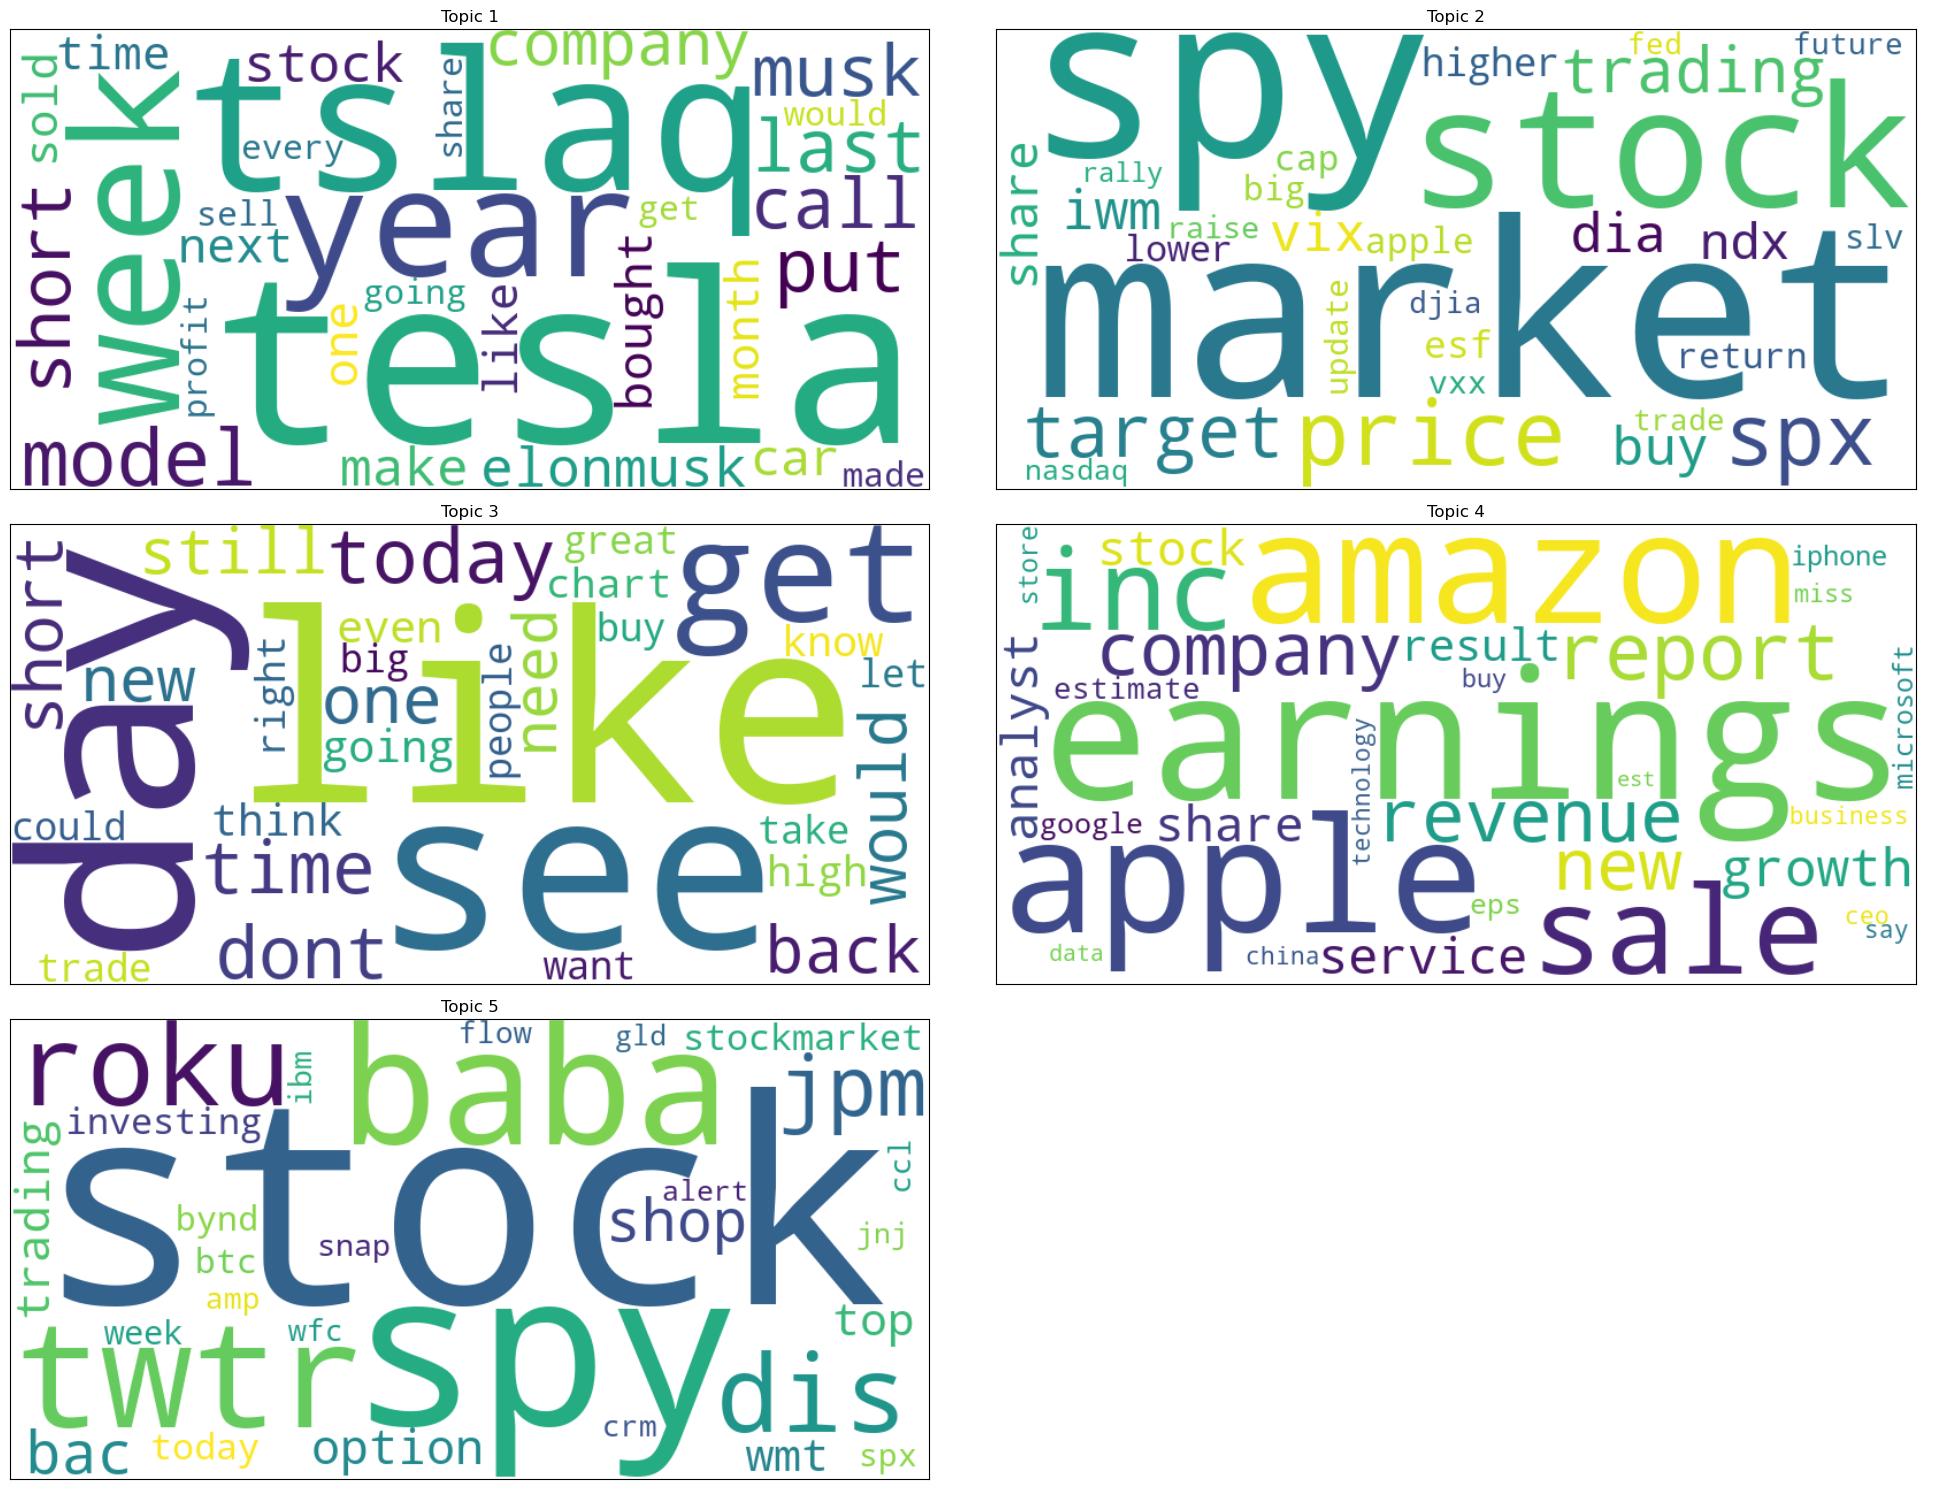

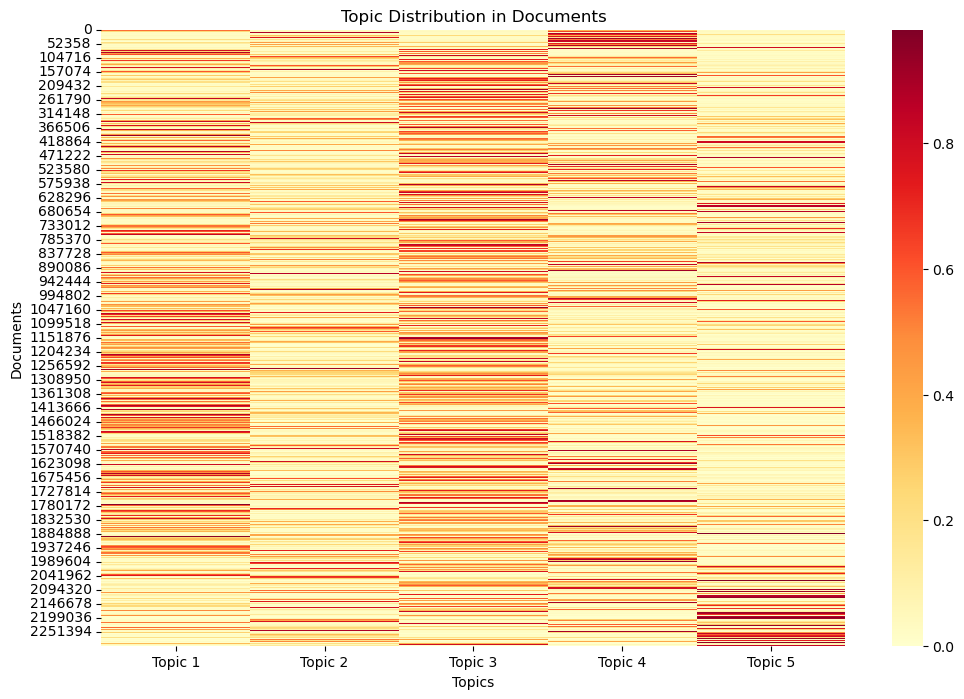

In [22]:
plot_All()

In [20]:
# Save model
dtm.save(r"notebooks\Luis\Entrega_4\models\lda")


In [21]:
# Perplexity
perplexity = dtm.log_perplexity(corpus)
print(f"Perplexity: {perplexity:.3f}")

Perplexity: -8.193


In [23]:
Perplexity = -8.193
# Make non-log
Perplexity = np.exp2(Perplexity)
Perplexity

0.003417127987913367